## I/O System Demo for  GeoidIO and SSHIO

### Import GeoidIO from gocean

In [75]:
import copy
from importlib import reload

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from gocean.io.geoid import GeoidIO

### Set the data directory for GeoidIO and read the .gdf file

In [76]:
# cdict = {
#   'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
#   'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
#   'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
# }
#
# cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

In [77]:
# Set the data directory to GeoidIO
geoid = GeoidIO(data_dir='../../data')

# READ required file
geoid.read('geoid.gdf')

### Let's view the data and header for the geoid

In [78]:
# Required header elements
print('header: \n')
for key in geoid.header.keys():
    print(key, ': ', geoid.header[key])

header: 

lat_max :  22.78
lat_min :  5.18
long_min :  77.77
long_max :  98.67
latitude_parallels :  177
longitude_parallels :  210


In [79]:
# Geoid Data
print('Data: \n', geoid.data)


Data: 
         long    lat      geoid
0      77.77  22.78 -58.897233
1      77.87  22.78 -58.982584
2      77.97  22.78 -59.060798
3      78.07  22.78 -59.127344
4      78.17  22.78 -59.178009
...      ...    ...        ...
37165  98.27   5.18 -20.974614
37166  98.37   5.18 -20.494548
37167  98.47   5.18 -19.996221
37168  98.57   5.18 -19.483223
37169  98.67   5.18 -18.961050

[37170 rows x 3 columns]


### Create a Geoid grid and visualize

In [80]:
# Create geoid grid
geoid.create_geoid_grid()

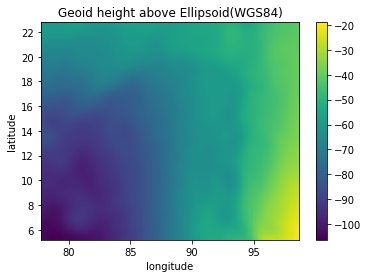

In [81]:
plt.imshow(geoid.grid[:, :, 2], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Geoid height above Ellipsoid(WGS84)')

plt.colorbar()
plt.savefig('geoid.png')
plt.show()

### Import SSHIO from gocean

In [82]:
from gocean.io.altimetry import SSHIO

### Set the data directory for jason and saral data

In [83]:
jason = SSHIO('../../data/altimetry')

### Read the SSH data and fill the similar grid as geoid

In [84]:
jason.read(geoid.grid)

### Visualize SSH from Jason and SARAL

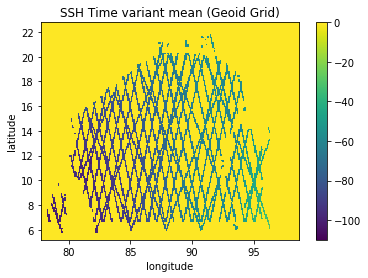

In [85]:
plt.imshow(jason.grid[:, :, 1], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('SSH Time variant mean (Geoid Grid)')

plt.colorbar()

plt.savefig('ssh-tvm.png')
plt.show()

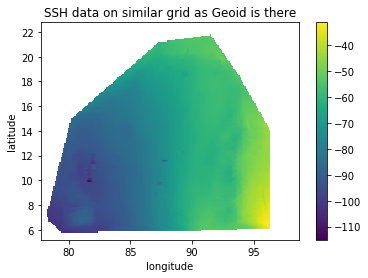

In [86]:
# plt.imshow(geoid.grid[:, :, 2], extent=[geoid.header['long_min'],
#                                         geoid.header['long_max'],
#                                         geoid.header['lat_min'],
#                                         geoid.header['lat_max']])
plt.imshow(jason.grid_filled[:, :], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('SSH data on similar grid as Geoid is there')

plt.colorbar()

plt.savefig('ssh.png')
plt.show()

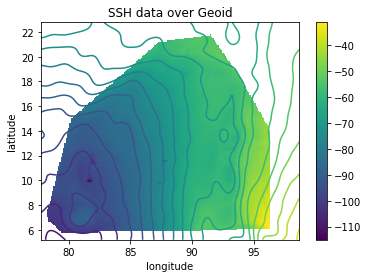

In [87]:
plt.contour(geoid.grid[:, :, 1], geoid.grid[:, :, 0],
            geoid.grid[:, :, 2], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']], levels=20)
plt.imshow(jason.grid_filled[:, :], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('SSH data over Geoid')

plt.colorbar()

plt.savefig('ssh-geoid.png')
plt.show()


### Import mdt from gocean.currents module

In [88]:
from gocean.currents.mdt import mdt

In [89]:
mdt_grid = mdt(geoid.grid[:, :, 2], jason.grid_filled)

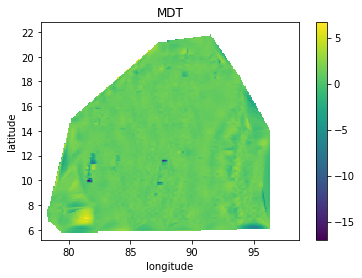

/home/shivam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


In [90]:
plt.imshow(mdt_grid, extent=[geoid.header['long_min'],
                             geoid.header['long_max'],
                             geoid.header['lat_min'],
                             geoid.header['lat_max']])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('MDT')

plt.colorbar()

plt.savefig('mdt.png')
plt.show()

jason.mask[np.where(mdt_grid<-6)] = True

In [91]:
mdt_grid[jason.mask] = np.nan

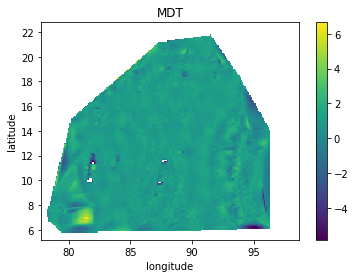

In [92]:
plt.imshow(mdt_grid, extent=[geoid.header['long_min'],
                             geoid.header['long_max'],
                             geoid.header['lat_min'],
                             geoid.header['lat_max']])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('MDT')

plt.colorbar()

plt.savefig('mdt_outl.png')
plt.show()

### Import filtering utility

In [93]:
from gocean.preprocessing.filters import gaussian

In [94]:
mdt_final = copy.copy(mdt_grid)
mdt_final[jason.mask] = 0

In [95]:
mdt_filtered = gaussian(mdt_final, jason.mask)

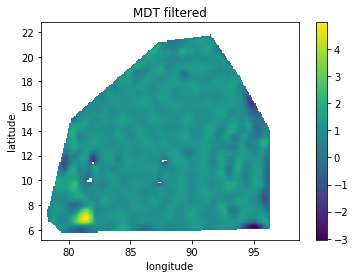

In [96]:
plt.imshow(mdt_filtered, extent=[geoid.header['long_min'],
                             geoid.header['long_max'],
                             geoid.header['lat_min'],
                             geoid.header['lat_max']])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('MDT filtered')

plt.colorbar()

plt.savefig('mdt-filtered.png')
plt.show()


In [97]:
from gocean.currents.current import decompose

In [98]:
u, v = decompose(mdt_final, geoid.grid[:, :, :2])

(177, 210)


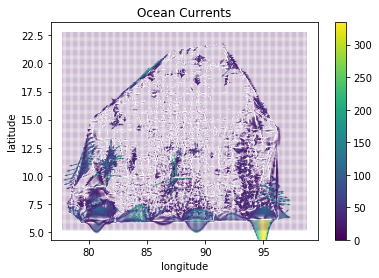

In [99]:
u[jason.mask] = 0
v[jason.mask] = 0

plt.quiver(geoid.grid[:, :, 1], geoid.grid[:, :, 0], v, u, np.sqrt(u**2+v**2))
plt.colorbar()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Ocean Currents')

plt.savefig('currents-overall.png')
plt.show()

In [113]:
row_block = 50
col_block = 50
for row in np.arange(0, 177, row_block):
    for col in np.arange(0, 210, col_block):
        row_begin = row
        row_end = row_begin+row_block
        if row_end > 177:
            row_end = 177

        col_begin = col
        col_end = col_begin+col_block
        if col_end > 177:
            col_end = 177
        plt.quiver(geoid.grid[row_begin:row_end, col_begin:col_end, 1],
                   geoid.grid[row_begin:row_end, col_begin:col_end, 0],
                   v[row_begin:row_end, col_begin:col_end],
                   u[row_begin:row_end, col_begin:col_end],
                   np.sqrt(u[row_begin:row_end, col_begin:col_end]**2+v[row_begin:row_end, col_begin:col_end]**2))
        plt.colorbar()

        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title('Ocean Currents')

        plt.savefig('currents/current'+str(row)+str(col)+'.png')
        plt.close()

/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:696: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:696: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:748: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:762: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength
/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:680: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
/home/shivam/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars

### Plot currents as unit vector and magnitude

In [101]:
mag = np.sqrt(u**2+v**2)
mag[jason.mask] = -1
mag[np.where(mag>90)] = -1
#
v_unit = copy.copy(v)
u_unit = copy.copy(u)

v_unit[jason.mask] = 0
u_unit[jason.mask] = 0

tmp_mask = np.invert(np.isclose(mag, -1))
# print(tmp_mask)
v_unit[tmp_mask] = v_unit[tmp_mask]/mag[tmp_mask]
u_unit[tmp_mask] = u_unit[tmp_mask]/mag[tmp_mask]
mag /= np.max(mag)

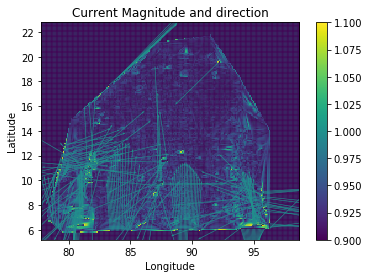

In [102]:
plt.imshow(mag, extent=[geoid.header['long_min'],
                             geoid.header['long_max'],
                             geoid.header['lat_min'],
                             geoid.header['lat_max']])
plt.quiver(geoid.grid[:, :, 1], geoid.grid[:, :, 0], v_unit, u_unit, 1)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.title('Current Magnitude and direction')
plt.savefig('Current-Components-with-mag.png')
plt.show()

In [103]:
# modeling
from sklearn.cluster import KMeans

In [104]:
curr = np.zeros([geoid.grid.shape[0], geoid.grid.shape[1], 3])
curr[:, :, 0] = mag
curr[:, :, 1] = v_unit
curr[:, :, 2] = u_unit
# curr[:, :, 3:] = geoid.grid[:, :, :2]

In [105]:
X = np.reshape(curr, newshape=[geoid.grid.shape[0]*geoid.grid.shape[1], 3])

kmeans = KMeans(n_clusters = 3,
                n_jobs = -1,
                random_state = 123).fit(X)
kmeans_df = pd.DataFrame(kmeans.cluster_centers_, columns = ['Magnitude', 'Longitude Direction', 'Latitude Direction'])

In [106]:
kmeans_df

,Magnitude,Longitude Direction,Latitude Direction
0,0.064143,0.055404,0.005492
1,-0.011125,-39.121479,-145.498031
2,-0.011125,17.707073,104.426790


In [107]:
import webcolors

In [108]:
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]
def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
    return closest_name
kmeans_df["Color Name"] = list(map(get_colour_name, np.uint8(kmeans.cluster_centers_[:, :3])))
kmeans_df

,Magnitude,Longitude Direction,Latitude Direction,Color Name
0,0.064143,0.055404,0.005492,black
1,-0.011125,-39.121479,-145.498031,springgreen
2,-0.011125,17.707073,104.426790,midnightblue


In [109]:
def replaceWithCentroid(kmeans):
    new_pixels = []
    for label in kmeans.labels_:
        pixel_as_centroid = list(kmeans.cluster_centers_[label])
        new_pixels.append(pixel_as_centroid)
    new_pixels = np.array(new_pixels).reshape(geoid.grid.shape[0]*geoid.grid.shape[1], -1)
    return new_pixels
new_pixels = replaceWithCentroid(kmeans)

In [110]:
new_pixels

array([[0.06414306, 0.05540388, 0.00549202],
       [0.06414306, 0.05540388, 0.00549202],
       [0.06414306, 0.05540388, 0.00549202],
       ...,
       [0.06414306, 0.05540388, 0.00549202],
       [0.06414306, 0.05540388, 0.00549202],
       [0.06414306, 0.05540388, 0.00549202]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


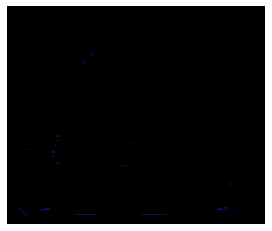

In [111]:
def plotImage(img_array, size):
    reload(plt)
    plt.imshow(np.array(img_array/255).reshape([geoid.grid.shape[0],
                                               geoid.grid.shape[1], 3])[:, :, :3])
    plt.axis('off')
    return plt

plotImage(new_pixels, new_pixels.shape).show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


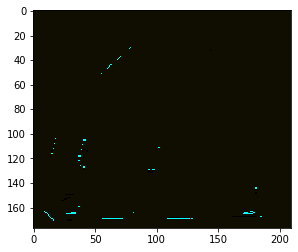

In [112]:
plt.imshow(new_pixels.reshape([geoid.grid.shape[0],
                                               geoid.grid.shape[1], 3]))
plt.savefig('k-means.png')
plt.show()